In [21]:
import folium
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
from lxml import etree
import requests
from IPython.display import display, HTML
import re
import matplotlib.pyplot as plt

In [2]:
projects= r'P3_GrantExport.csv'
state_data = pd.read_csv(projects, sep=';')
state_data.set_index(state_data.columns[0], inplace=True)
state_data = state_data[['University', 'Approved Amount']]
state_data.dropna(subset=['University'], inplace=True)
state_data = state_data[state_data['University'] != 'Nicht zuteilbar - NA'] #Nicht zuteilbar = NA University
state_data = state_data[state_data['University'] != 'NPO (Biblioth., Museen, Verwalt.) - NPO'] #NPO = is not university

In [3]:
index = state_data[state_data['Approved Amount'] == 'data not included in P3'].index
state_data = state_data.drop(index)

In [4]:

def getData(project_id):
    url = 'http://p3.snf.ch'
    url_project = url + '/project-' + str(project_id)
    # We parse the response to analyze it 
    soup_project = BeautifulSoup(requests.request("GET", url_project).text, 'html.parser')
    id_institute = soup_project.find(id="ctl00_MainContent_urlInstitite").get('href')
    if id_institute is None:
        return None
    
    url_institute = url + id_institute
    
    toSoup = requests.request("GET", url_institute)
    soup_institute = BeautifulSoup(toSoup.text, 'html5lib')
    table = soup_institute.findAll('div', {'class': 'institute'})[0].findAll('td')[1].text
    p = re.compile("CH-\S{4}")
    match = p.search(table)
    
    if match is None:
        return None
    #print(project_id, match.group(0))
    postal_code = match.group(0)
    return postal_code

In [5]:
def search_missing_cantons(UniCanton):
    for i in range(len(UniCanton)):
        if UniCanton['Canton'].iloc[i] == 'NaN':
            query = getData(temp.index.values[i])
            if query is not None:
                canton = searchCantonGeoNames(query)
            UniCanton['Canton'].iloc[i] = canton
    return UniCanton


In [6]:
def searchCantonGeoNames(query1, query2=None): #returns in which canton the university is in
    url = 'http://api.geonames.org/searchJSON?country=CH&maxRows=1&username=jnls'
    payload = {'q': query1 }
    req = requests.get(url, params=payload)
    req_json = json.loads(req.text)
    if req_json['totalResultsCount'] > 0:
        return req_json['geonames'][0]['adminCode1']
    elif req_json['totalResultsCount'] == 0 and query2 is not None:
        payload = {'q': query2 }
        req = requests.get(url, params=payload)
        req_json = json.loads(req.text)
        if req_json['totalResultsCount'] > 0:
            return req_json['geonames'][0]['adminCode1']
        else:
            return "NaN"
def search_cantons(data):
    UniCanton = data['University'].drop_duplicates().to_frame()
    UniCanton['Canton'] = ''
    for i in range(len(UniCanton)):
        query = UniCanton['University'].iloc[i].split(" - ")
        if len(query) > 1:
            canton = searchCantonGeoNames(query[0], query[1])
        else:
            canton = searchCantonGeoNames(query[0])
        UniCanton['Canton'].iloc[i] = canton
    #data = data[data['Canton'] != 'NaN'] 
    return UniCanton

temp = search_cantons(state_data)
temp = search_missing_cantons(temp)

In [7]:
temp.head()

,University,Canton
"﻿""Project Number""",,
4,Université de Genève - GE,GE
6,Universität Basel - BS,BS
8,Université de Fribourg - FR,FR
10,Universität Zürich - ZH,ZH
11,Université de Lausanne - LA,VD


In [8]:
temp[temp['Canton'].isnull()]['University']

﻿"Project Number"
260                  Pädagogische Hochschule Zürich - PHZFH
3315      Swiss Center for Electronics and Microtech. - ...
10947              Università della Svizzera italiana - USI
26632     Centre de rech. sur l'environnement alpin - CR...
59733                       Fachhochschule Ostschweiz - FHO
101005                            Forschungskommission SAGW
139469                  Facoltà di Teologia di Lugano - FTL
Name: University, dtype: object

In [9]:
temp['Canton'].loc[260] = 'ZH'
temp['Canton'].loc[3315] = 'VS'
temp['Canton'].loc[10947] = 'TI' 
temp['Canton'].loc[26632] = 'VS'
temp['Canton'].loc[59733] = 'SG'
temp['Canton'].loc[101005] = 'BE'
temp['Canton'].loc[139469] = 'TI'


In [10]:
temp.set_index(temp.University, inplace=True, drop=True)
temp = temp.to_dict()['Canton']
state_data['Canton'] = state_data['University'].map(temp)
state_data.reset_index(drop=True, inplace=True)
grants = state_data.drop('University', 1)
grants['Approved Amount'] = grants['Approved Amount'].convert_objects(convert_numeric=True)
grants_sum = grants.groupby(grants.Canton).sum()/10**6
grant_canton = grants_sum['Approved Amount'].to_dict()


/Users/juanluismoralperez/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [11]:
cantonMap = pd.DataFrame({'Canton':['JU', 'ZH', 'BE', 'LU', 'SG', 'NE', 
                                    'VD', 'VS', 'GE', 'TI', 'SO', 'UR', 
                                    'OW', 'NW', 'SZ', 'GL', 'ZG', 'BL', 
                                    'BS', 'FR', 'SH', 'AR', 'AI', 'GR', 
                                    'AG', 'TG']})
cantonMap['Grants'] = 0
cantonMap['Grants'] = cantonMap['Canton'].map(grant_canton)

ch_geo = r'ch-cantons.topojson.json'

mapCH = folium.Map(location=[46.82244,8.22410], zoom_start=8)
mapCH.choropleth(data=cantonMap, 
                columns=['Canton', 'Grants'], 
                geo_path=ch_geo,
                topojson='objects.cantons', 
                fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                key_on='feature.id')
mapCH.save('ch-cantons.html')

/Users/juanluismoralperez/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


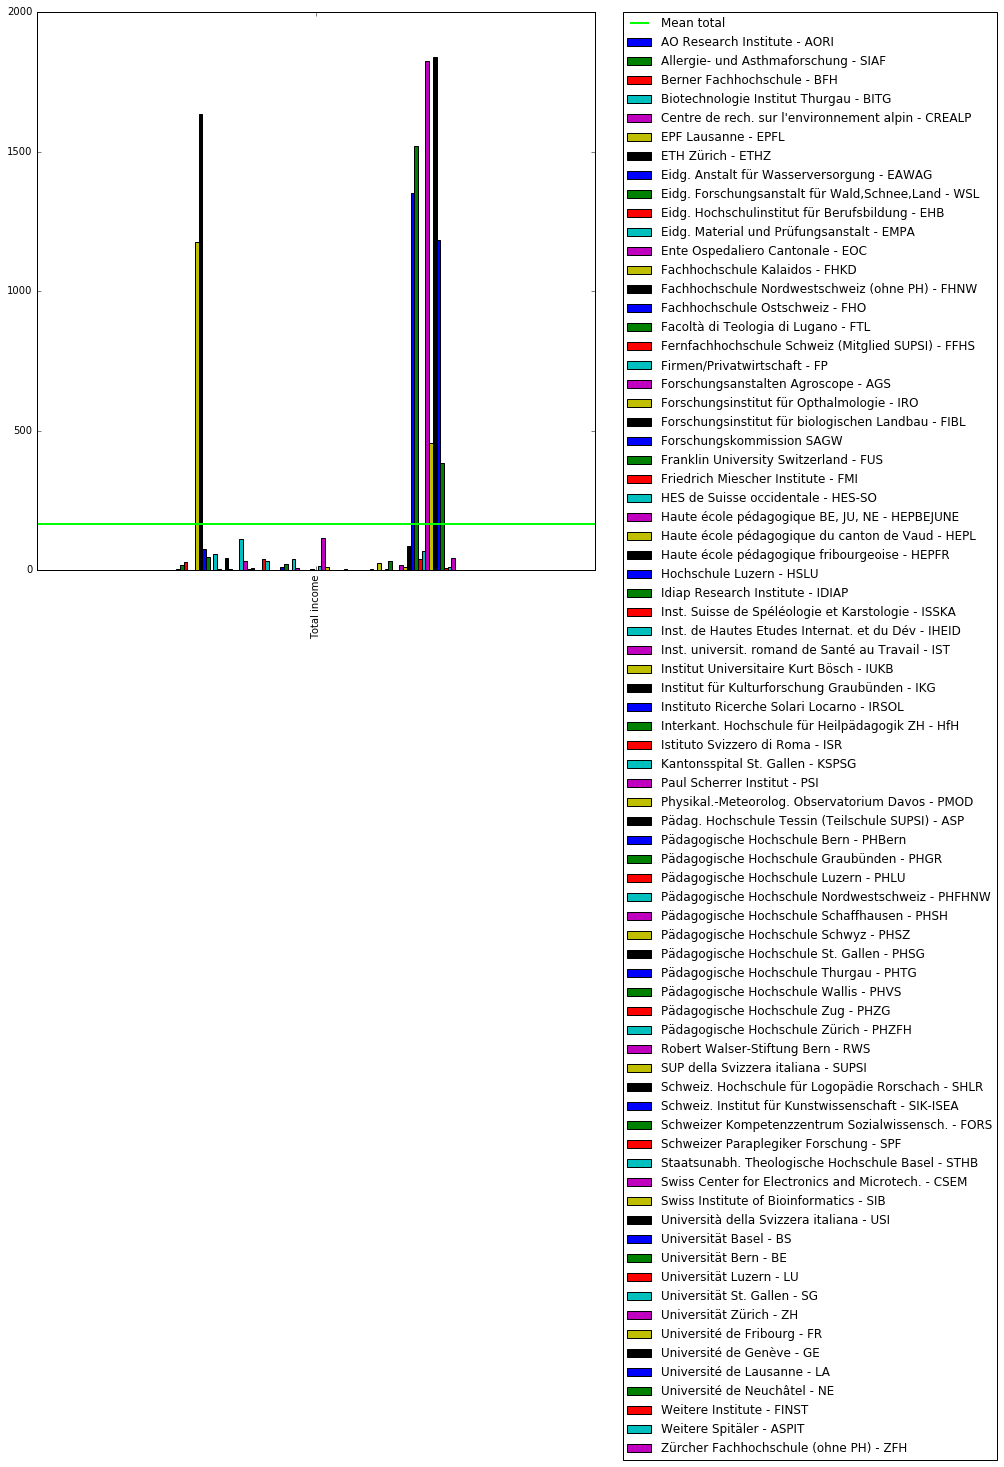

In [22]:
moneyXuni = {}
for university in np.unique(state_data['University'].values):
    moneyXuni[university] = sum(state_data[state_data['University'] == university ]['Approved Amount'].values.astype(np.float))/10**6

data_MU = pd.DataFrame(moneyXuni, index = ['Total income']) #data Money per University
%matplotlib inline
data_MU.plot.bar(figsize=(10, 10))
mean = sum(list(moneyXuni.values())) / len(moneyXuni)
plt.axhline(y = mean, xmin=0, xmax=1, hold=None, color='#00FF00', linewidth = 2.0, label = 'Mean total')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In the last graph, we can see some Universities that surpass mean, but it is a little bit difficult to differenciate what are these, so the next step is to search this Universities

In [18]:
selected_uni = (data_MU.transpose()[data_MU.transpose()['Total income'] > mean]).sort_values(by =['Total income'])
selected_uni

,Total income
Université de Neuchâtel - NE,383.204582
Université de Fribourg - FR,457.526170
EPF Lausanne - EPFL,1175.315914
Université de Lausanne - LA,1183.290757
Universität Basel - BS,1352.251464
Universität Bern - BE,1519.373035
ETH Zürich - ETHZ,1635.596618
Universität Zürich - ZH,1826.842675
Université de Genève - GE,1838.237308


/Users/juanluismoralperez/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


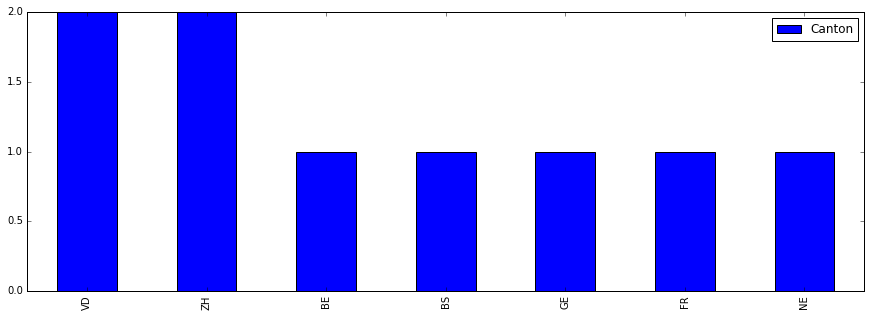

In [19]:
selected_uni['Canton'] = ''
for i in selected_uni.index:
    selected_uni['Canton'].loc[i] = np.unique(state_data[state_data['University'] == i]['Canton'].values)[0]
(pd.DataFrame(selected_uni['Canton'].value_counts())).plot.bar(figsize=(15, 5))

In this graph, we can see the number of universities in each canton, which exceed the average.

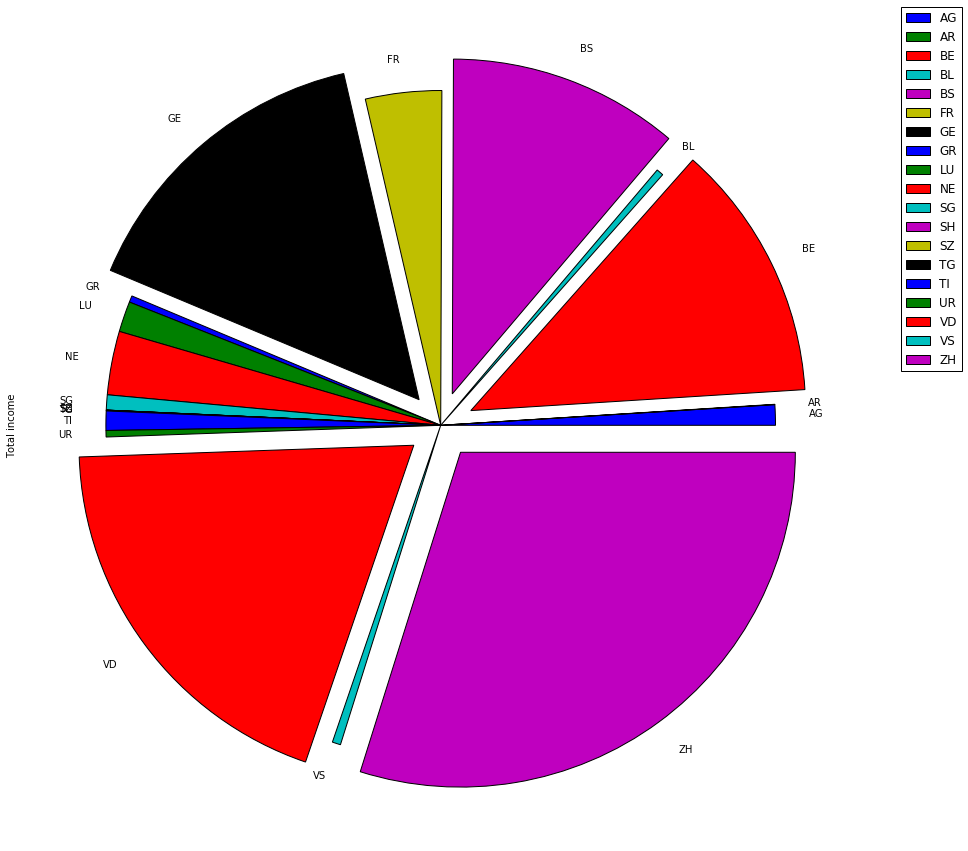

In [27]:
money = {}
for canton in np.unique(state_data['Canton'].values):
    money[canton] = sum(state_data[state_data['Canton'] == canton]['Approved Amount'].values.astype(np.float)/10**6)

money = (pd.DataFrame(money, index = ['Total income'])).transpose()
mean = np.mean(money['Total income'].values)
explode = (money['Total income']> mean)*0.1
money.plot.pie(subplots=True, explode = explode, figsize=(15, 15))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()  

We can see in this *PIE GRAPH*, the pieces are a bit away from the center, are those that exceed the average. If we compare this with the **histogram graph**, we can see that the *Cantones*: **NE** y **FR** not appear. It may be that these two cantons are formed by a single university. As we can see in the diagram below, they are in the cantons, which have not appointed one/a few  university/universities receive more money compared to the rest.

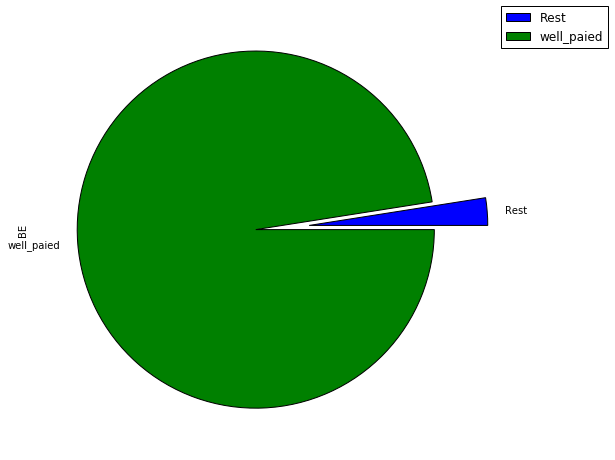

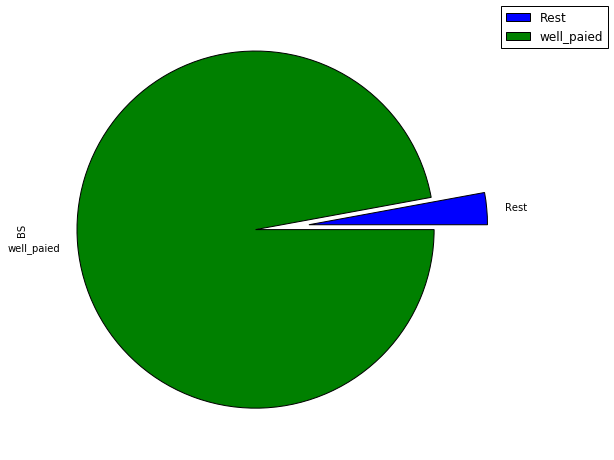

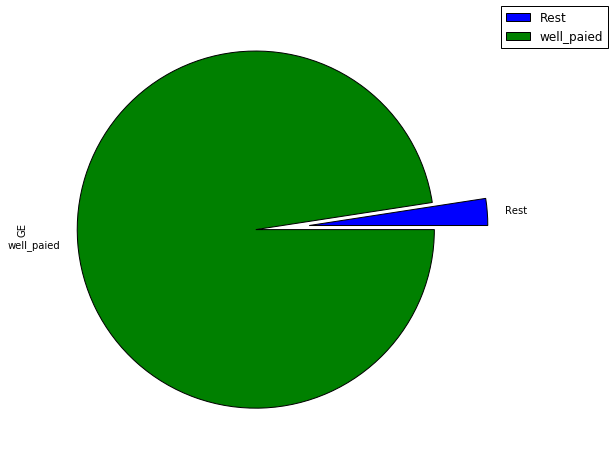

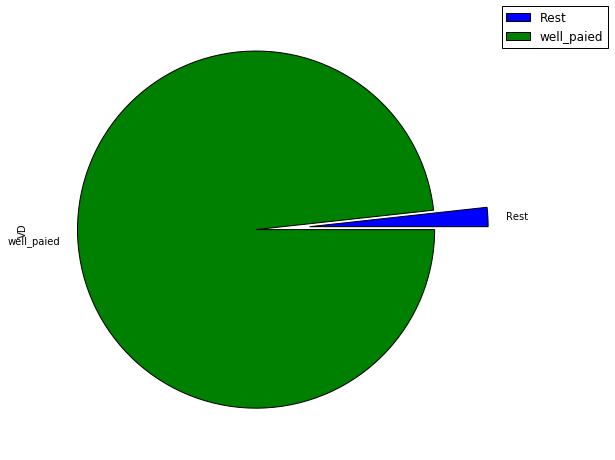

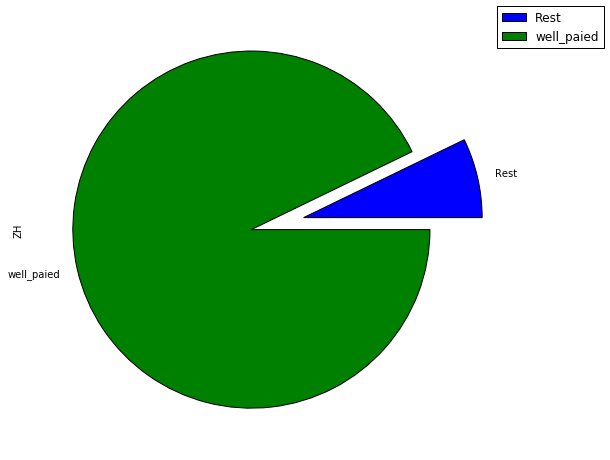

In [63]:
for i in money[money['Total income']> mean].index:
    total_best_universities = sum(selected_uni[selected_uni['Canton'] == i]['Total income'].values)
    rest = sum(money.loc[i].values) - total_best_universities
    pd.DataFrame({'well_paied' : [total_best_universities], 'Rest' : [rest]}, 
                 index = [i]).transpose().plot.pie(subplots=True, figsize=(8, 8), explode = [0.3, 0])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show() 